# Guided 3: Computer Vision

# Bagian 1: Klasifikasi Angka MNIST

Pada bagian pertama dari praktikum ini, kita akan membangun dan melatih *Convolutional Neural Network* (CNN) untuk melakukan klasifikasi terhadap angka tulisan tangan menggunakan dataset terkenal [MNIST](http://yann.lecun.com/exdb/mnist/). Dataset MNIST terdiri dari 60.000 gambar pelatihan dan 10.000 gambar pengujian. Kelas yang akan kita klasifikasikan adalah digit angka 0 hingga 9.

Langkah pertama, mari kita unduh repositori kursus, instal dependensi yang dibutuhkan, dan impor paket-paket relevan yang akan digunakan dalam praktikum ini.


In [2]:
# Import Tensorflow 2.0
# !pip install tensorflow
import tensorflow as tf

# MIT introduction to deep learning package
#!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# other packages
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

2025-09-03 07:52:04.165896: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 07:52:04.185018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756860724.206754    9833 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756860724.213692    9833 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 07:52:04.237274: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Kita juga akan menginstal **Comet**. Jika kamu telah mengikuti instruksi dari *Lab 1*, seharusnya akun Comet-mu sudah siap digunakan.  
Masukkan **API key**-mu pada bagian di bawah ini.

In [ ]:
#!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = "API_KEY_HERE"

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

In [ ]:
# start a first comet experiment for the first part of the lab
comet_ml.init(project_name="NPM_MODUL3")
comet_model_1 = comet_ml.Experiment()

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, sklearn, tensorflow, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/sigitpurnomo/6s191-lab2-part1-nn/ccb389d7f2424b97ab5e7a4ca68d80a4

COMET INFO: Couldn't find a Git repository in '/home/jupyter-sigitpurnomo/teaching/dl' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


## 1.1 Dataset MNIST

Mari kita unduh dan muat dataset tersebut, lalu tampilkan beberapa contoh sampel acak dari dataset ini:

In [6]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

Dataset pelatihan kita terdiri dari gambar angka tulisan tangan berukuran 28x28 piksel dalam skala abu-abu (*grayscale*).

Mari kita visualisasikan beberapa gambar tersebut beserta label pelatihannya masing-masing.

{'web': 'https://www.comet.com/api/image/download?imageId=05980010618045aca89915f60bd9ef29&experimentKey=ccb389d7f2424b97ab5e7a4ca68d80a4',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=05980010618045aca89915f60bd9ef29&experimentKey=ccb389d7f2424b97ab5e7a4ca68d80a4',
 'imageId': '05980010618045aca89915f60bd9ef29'}

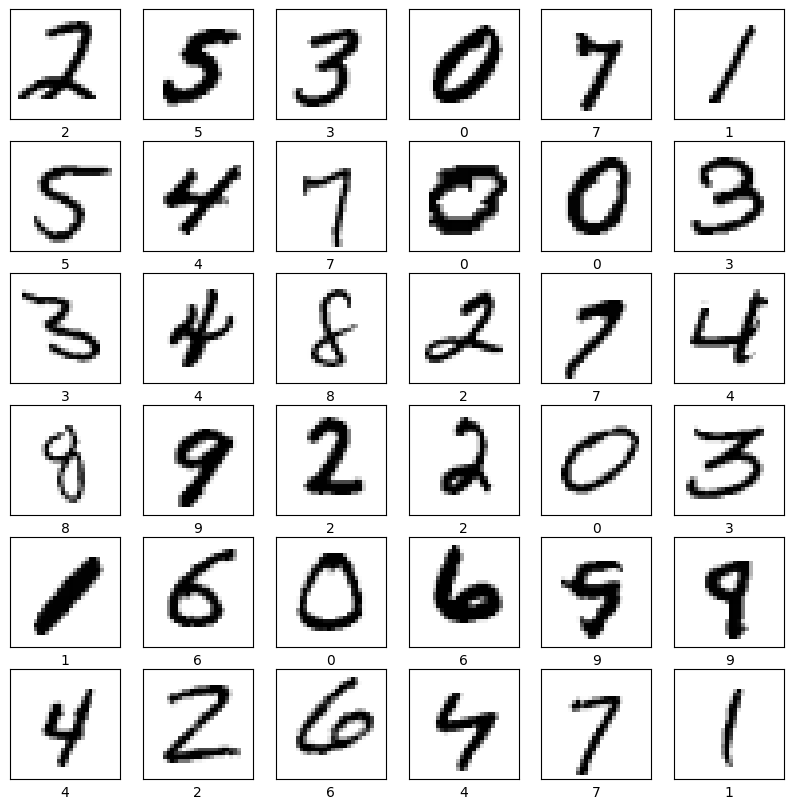

In [7]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])
comet_model_1.log_figure(figure=plt)

## 1.2 Jaringan Saraf untuk Klasifikasi Angka Tulisan Tangan

Kita akan terlebih dahulu membangun sebuah jaringan saraf sederhana yang terdiri dari dua *fully connected layer* (lapisan terhubung penuh), lalu menerapkannya pada tugas klasifikasi angka tulisan tangan.  
Jaringan ini nantinya akan menghasilkan **distribusi probabilitas** untuk sepuluh kelas digit (0–9).

Arsitektur pertama yang akan kita bangun digambarkan seperti di bawah ini:

![alt_text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "Arsitektur CNN untuk Klasifikasi MNIST")

### Arsitektur Jaringan Saraf Fully Connected

Untuk mendefinisikan arsitektur dari jaringan saraf *fully connected* pertama ini, kita akan kembali menggunakan **Keras API** dan membangun model dengan kelas [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential).  
Perhatikan bahwa kita terlebih dahulu menggunakan lapisan [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), yang berfungsi untuk **mengubah input menjadi satu dimensi** agar dapat diproses oleh model.

Pada blok kode berikutnya, kamu akan mendefinisikan lapisan-lapisan *fully connected* dari model sederhana ini.


In [ ]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # Pertama, kita definisikan lapisan Flatten
      # Flatten berfungsi untuk mengubah input gambar 28x28 piksel menjadi vektor 1 dimensi
      tf.keras.layers.Flatten(),

      # TODO: Tentukan fungsi aktivasi untuk lapisan Dense (fully connected) pertama
      # Di sini digunakan ReLU (Rectified Linear Unit) untuk memperkenalkan non-linearitas ke dalam model
      tf.keras.layers.Dense(128, activation=tf.nn.____), # TODO (10)

      # TODO: Definisikan lapisan Dense kedua untuk menghasilkan probabilitas klasifikasi
      # Lapisan ini memiliki 10 neuron karena terdapat 10 kelas (digit 0–9)
      # Fungsi aktivasi softmax digunakan agar output menjadi distribusi probabilitas
      tf.keras.layers.Dense(10, activation=tf.nn.____)  # TODO (10)
  ])
  return fc_model

# Membuat model dengan memanggil fungsi build_fc_model()
model = build_fc_model()

Saat kita melanjutkan ke bagian berikutnya, mungkin kamu akan ingin melakukan beberapa perubahan pada arsitektur model yang telah didefinisikan di atas.  
**Perlu diperhatikan bahwa untuk memperbarui model nantinya, kamu harus menjalankan ulang sel kode di atas agar model terinisialisasi kembali dari awal.**

Mari kita mundur sejenak dan pikirkan kembali jaringan yang baru saja kita buat.  
Lapisan pertama dalam jaringan ini, yaitu `tf.keras.layers.Flatten`, mengubah format gambar dari **array 2 dimensi (28 x 28 piksel)** menjadi **array 1 dimensi berisi 28 * 28 = 784 piksel**.  
Kamu bisa membayangkan lapisan ini seperti **“membentangkan” baris-baris piksel dari gambar menjadi satu deretan panjang**.  
Lapisan ini **tidak memiliki parameter yang dipelajari**, karena fungsinya hanya untuk mengubah bentuk (reformat) data.

Setelah piksel di-*flatten*, jaringan kita terdiri dari dua lapisan `tf.keras.layers.Dense` berturut-turut, yang merupakan **lapisan neural terhubung penuh (fully connected layers)**.  
Lapisan Dense pertama memiliki **128 node (neuron)**, sedangkan lapisan kedua (yang sudah kamu definisikan) akan menghasilkan **array berisi skor probabilitas yang totalnya berjumlah 1**.  

Setiap node pada lapisan keluaran ini memberikan nilai probabilitas yang menunjukkan **seberapa besar kemungkinan gambar tersebut termasuk ke dalam salah satu kelas digit tulisan tangan (0–9)**.

Dengan demikian, kita telah berhasil mendefinisikan **model fully connected pertama kita!**

### Compile Model

Sebelum melatih model, kita perlu mendefinisikan beberapa pengaturan tambahan.  
Pengaturan ini ditentukan pada langkah [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) dari model:

* **Fungsi Loss (Loss function)** — Menentukan bagaimana kita mengukur tingkat akurasi model selama proses pelatihan.  
  Seperti yang dijelaskan dalam kuliah, selama pelatihan kita berusaha untuk **meminimalkan nilai loss**, karena hal ini akan membantu “mengarahkan” model agar belajar dengan benar.

* **Optimizer** — Menentukan bagaimana model diperbarui berdasarkan data yang diterimanya dan nilai loss yang dihasilkan.  
  Optimizer bertugas menyesuaikan bobot-bobot jaringan agar hasil prediksi semakin mendekati target yang benar.

* **Metrics** — Menentukan metrik yang digunakan untuk memantau kinerja model selama proses pelatihan dan pengujian.  
  Dalam contoh ini, kita akan menggunakan **akurasi (accuracy)**, yaitu persentase gambar yang berhasil diklasifikasikan dengan benar.

Kita akan memulai dengan menggunakan **optimizer Stochastic Gradient Descent (SGD)** dengan **learning rate sebesar 0.1**.  
Karena tugas yang kita lakukan adalah **klasifikasi kategori (categorical classification)**, maka kita akan menggunakan **cross entropy loss**  
([`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy)) sebagai fungsi loss.

Kamu disarankan untuk bereksperimen dengan berbagai pilihan **optimizer** dan **learning rate**, lalu mengevaluasi bagaimana perubahan tersebut memengaruhi akurasi model yang telah dilatih.


In [ ]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-1),
              loss='____',
              metrics=['____']) #TODO (10)

I0000 00:00:1756860742.946980    9833 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42547 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:16:00.0, compute capability: 8.9
I0000 00:00:1756860742.948662    9833 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 42923 MB memory:  -> device: 1, name: NVIDIA L40S, pci bus id: 0000:be:00.0, compute capability: 8.9


### Train Model

Sekarang kita siap untuk melatih model kita.  
Proses pelatihan ini melibatkan **pemberian data pelatihan (`train_images` dan `train_labels`) ke dalam model**,  
lalu meminta model untuk **mempelajari hubungan antara gambar dan label** yang sesuai.  

Kita juga perlu menentukan **ukuran batch (batch size)** dan **jumlah epoch**, yaitu berapa kali model akan melakukan iterasi penuh terhadap dataset MNIST selama pelatihan.

Pada *Lab 1*, kita telah melihat bagaimana menggunakan `GradientTape` untuk mengoptimalkan nilai *loss* dan melatih model menggunakan metode *stochastic gradient descent*.  
Namun, setelah kita mendefinisikan pengaturan model pada langkah `compile`, kita juga dapat melakukan proses pelatihan dengan cara yang lebih sederhana —  
yaitu dengan memanggil metode [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) dari kelas `Model`.

Kita akan menggunakan metode `fit` ini untuk **melatih model fully connected** yang telah kita buat sebelumnya.

In [10]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 64
EPOCHS = 5

model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS)
comet_model_1.end()

Epoch 1/5


I0000 00:00:1756860743.853446   10147 service.cc:148] XLA service 0x7f2838017760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756860743.853570   10147 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
I0000 00:00:1756860743.853580   10147 service.cc:156]   StreamExecutor device (1): NVIDIA L40S, Compute Capability 8.9
2025-09-03 07:52:23.887416: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1756860743.958979   10147 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-09-03 07:52:25.708335: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_166', 224 bytes spill stores, 224 bytes spill loads

2025-09-03 07:52:25.712454: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compile

 24/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3763 - loss: 1.9362  

I0000 00:00:1756860746.583895   10147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8383 - loss: 0.5886

2025-09-03 07:52:33.808384: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_166', 8 bytes spill stores, 8 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8385 - loss: 0.5879
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9401 - loss: 0.2151
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9552 - loss: 0.1539
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9633 - loss: 0.1272
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9701 - loss: 0.1044


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : wise_landing_7181
COMET INFO:     url                   : https://www.comet.com/sigitpurnomo/6s191-lab2-part1-nn/ccb389d7f2424b97ab5e7a4ca68d80a4
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, sklearn, tensorflow, torch.


Selama proses pelatihan, metrik **loss** dan **akurasi (accuracy)** akan ditampilkan.  
Dengan menjalankan model selama **lima epoch** dan menggunakan **learning rate sebesar 0,01**,  
model *fully connected* ini seharusnya dapat mencapai **akurasi sekitar 0,97 (atau 97%)** pada data pelatihan.

### Mengevaluasi Akurasi pada Dataset Uji

Sekarang setelah model kita selesai dilatih, kita dapat memintanya untuk **membuat prediksi terhadap data uji** yang belum pernah dilihat sebelumnya.  
Dalam contoh ini, array `test_images` berisi dataset uji yang akan kita gunakan.  

Untuk mengevaluasi akurasi model, kita akan membandingkan **hasil prediksi model** dengan **label sebenarnya** yang terdapat pada array `test_labels`.

Gunakan metode [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate)  
untuk menguji performa model pada dataset uji!

In [ ]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(____, ____) # TODO (10)

print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9632 - loss: 0.1209
Test accuracy: 0.9692000150680542


Kamu mungkin memperhatikan bahwa akurasi pada dataset uji sedikit lebih rendah daripada akurasi pada dataset pelatihan. Selisih antara akurasi pelatihan dan akurasi uji ini merupakan contoh dari *overfitting*, yaitu ketika sebuah model machine learning berkinerja lebih buruk pada data baru dibandingkan pada data yang digunakan untuk pelatihan.

Berapa akurasi tertinggi yang bisa kamu capai dengan model fully connected pertama ini? Karena tugas klasifikasi angka tulisan tangan relatif sederhana, kamu mungkin bertanya-tanya bagaimana caranya agar hasilnya menjadi lebih baik...

![Deeper...](https://i.kym-cdn.com/photos/images/newsfeed/000/534/153/f87.jpg)

---

**Ringkasan singkat:**  
- Akurasi pada data uji biasanya sedikit lebih rendah daripada pada data pelatihan — ini normal dan bisa menunjukkan *overfitting*.  
- Pertanyaan penting: seberapa tinggi akurasi yang bisa dicapai oleh model sederhana ini?  
- Karena tugas ini cukup mudah, ada ruang untuk meningkatkan performa (mis. dengan arsitektur yang lebih baik, regularisasi, atau teknik pelatihan lain).

## 1.3 Convolutional Neural Network (CNN) untuk Klasifikasi Angka Tulisan Tangan

Seperti yang telah kita bahas dalam perkuliahan, **Convolutional Neural Networks (CNN)** sangat cocok digunakan untuk berbagai tugas dalam bidang *computer vision*,  
dan bahkan telah mencapai **akurasi yang hampir sempurna** pada dataset MNIST.

Sekarang, kita akan membangun sebuah CNN yang terdiri dari:
- Dua **lapisan konvolusi (convolutional layers)** beserta **lapisan pooling**,  
- Diikuti oleh dua **lapisan fully connected**,  
- Dan pada akhirnya menghasilkan **distribusi probabilitas** untuk sepuluh kelas digit (0–9).

Arsitektur CNN yang akan kita bangun digambarkan seperti di bawah ini:

![alt_text](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/master/lab2/img/convnet_fig.png "Arsitektur CNN untuk Klasifikasi MNIST")


### Mendefinisikan Model CNN

Kita akan menggunakan dataset pelatihan dan pengujian yang sama seperti sebelumnya,  
dan melanjutkan prosesnya dengan cara yang mirip seperti model *fully connected* sebelumnya,  
namun kali ini untuk **mendefinisikan dan melatih model CNN baru**.

Untuk membangun CNN, kita akan memperkenalkan dua jenis lapisan baru yang belum digunakan sebelumnya:
- [`keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) — digunakan untuk mendefinisikan **lapisan konvolusi** (*convolutional layer*), yang berfungsi mendeteksi fitur seperti tepi, pola, atau bentuk pada gambar.  
- [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) — digunakan untuk mendefinisikan **lapisan pooling**, yang berfungsi mengurangi dimensi spasial dari representasi fitur sambil mempertahankan informasi penting.

Gunakan parameter-parameter yang ditunjukkan pada arsitektur jaringan di atas  
untuk mendefinisikan lapisan-lapisan ini dan membangun model CNN sepenuhnya.

In [ ]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(filters=24, kernel_size=(____,____), activation=tf.nn.relu),

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(____,____)),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters=36, kernel_size=(____,____), activation=tf.nn.relu),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size=(____,____)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification
        # probabilities. Pay attention to the activation needed a probability output
        tf.keras.layers.Dense(____, activation=tf.nn.softmax)
    ])

    return cnn_model

cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (1, 26, 26, 24)        │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (1, 13, 13, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 11, 11, 36)        │         7,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (1, 5, 5, 36)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 900)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 128)               │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1, 10)                │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,670 (486.99 KB)

 Trainable params: 124,670 (486.99 KB)

 Non-trainable params: 0 (0.00 B)

None


### Melatih dan Menguji Model CNN

Sama seperti sebelumnya, kita dapat mendefinisikan **fungsi loss**, **optimizer**, dan **metrik evaluasi** melalui metode `compile`.  
Langkah ini akan menentukan bagaimana model CNN belajar dari data dan bagaimana performanya diukur selama pelatihan.

Kompilasikan model CNN dengan **optimizer** dan **learning rate** yang kamu pilih sendiri:

In [ ]:
comet_ml.init(project_name="NPM_MODUL3")
comet_model_2 = comet_ml.Experiment()

'''TODO: Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='________________________',
              metrics=['________'])# TODO (10)

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, sklearn, tensorflow, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/jupyter-sigitpurnomo/teaching/dl' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/sigitpurnomo/6-s191lab2-part1-cnn/832c576c706b4b899b5a151307f2ee42



Sama seperti pada model *fully connected* sebelumnya, kita dapat melatih model CNN kita menggunakan metode `fit` melalui **Keras API**.

In [ ]:
'''TODO: Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
cnn_model.fit(____, ____, batch_size=____, epochs=____) # TODO (10)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8807 - loss: 0.4121
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9813 - loss: 0.0606
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9869 - loss: 0.0416
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9901 - loss: 0.0314
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9926 - loss: 0.0231


Bagus! Sekarang setelah model kita selesai dilatih, mari kita evaluasi performanya pada dataset uji  
dengan menggunakan metode [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate):

In [ ]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(____, ____) # TODO (10)

print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9858 - loss: 0.0415
Test accuracy: 0.9896000027656555


Berapa akurasi tertinggi yang berhasil kamu capai menggunakan model CNN?  
Dan bagaimana perbandingan akurasi model CNN tersebut dengan akurasi dari model *fully connected* sederhana sebelumnya?

Coba perhatikan juga **optimizer** dan **learning rate** mana yang memberikan hasil paling optimal saat melatih model CNN.

Kamu dapat mengklik tautan **Comet** untuk menelusuri lebih dalam *training curve* dan *accuracy curve* dari modelmu,
agar bisa memahami bagaimana performanya berkembang selama proses pelatihan.

### Membuat Prediksi dengan Model CNN

Setelah model selesai dilatih, kita dapat menggunakannya untuk **membuat prediksi terhadap beberapa gambar**.  
Pemanggilan fungsi [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict)  
akan menghasilkan **output prediksi** berdasarkan sekumpulan sampel input yang diberikan.


In [16]:
predictions = cnn_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


Dengan pemanggilan fungsi ini, model telah **memprediksi label untuk setiap gambar** dalam dataset pengujian.  
Sekarang, mari kita lihat **hasil prediksi untuk gambar pertama** di dataset uji:

In [17]:
predictions[0]

array([2.2790800e-09, 2.1768881e-07, 2.2381472e-07, 9.9214230e-07,
       2.6610765e-09, 2.8772160e-09, 6.3073224e-15, 9.9999833e-01,
       3.7019732e-09, 2.4356359e-07], dtype=float32)

Seperti yang dapat kamu lihat, hasil prediksi berupa **array yang berisi 10 angka**.  
Ingat bahwa keluaran model kita adalah **distribusi probabilitas** untuk sepuluh kelas digit (0–9).  
Oleh karena itu, setiap angka dalam array tersebut menunjukkan **tingkat keyakinan (confidence)** model  
bahwa gambar tersebut termasuk ke dalam masing-masing kelas digit.

Sekarang, mari kita lihat **digit dengan tingkat keyakinan tertinggi** untuk gambar pertama dalam dataset uji:

In [ ]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = np.argmax(____[0]) # TODO (10)

print(prediction)

7


Jadi, model paling yakin bahwa gambar ini merupakan angka “7”.  
Kita dapat memeriksa **label sebenarnya dari dataset uji** (ingat, ini adalah identitas asli dari digit tersebut)  
untuk memastikan apakah prediksi model tersebut benar atau tidak:

Label of this digit is: 7


{'web': 'https://www.comet.com/api/image/download?imageId=bd04262532934561b4ca5dabac423cf5&experimentKey=832c576c706b4b899b5a151307f2ee42',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=bd04262532934561b4ca5dabac423cf5&experimentKey=832c576c706b4b899b5a151307f2ee42',
 'imageId': 'bd04262532934561b4ca5dabac423cf5'}

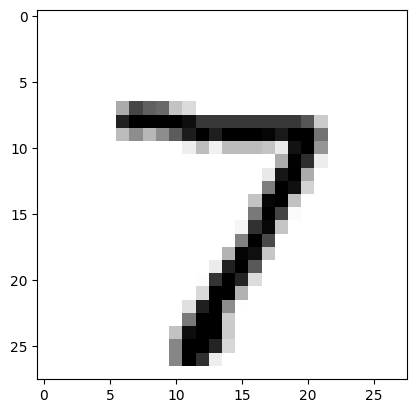

In [19]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)
comet_model_2.log_figure(figure=plt)

Benar!
Sekarang, mari kita **visualisasikan hasil klasifikasi** pada dataset MNIST.  

Kita akan menampilkan beberapa gambar dari dataset uji beserta **label yang diprediksi oleh model**,  
serta menambahkan **histogram** yang menunjukkan **probabilitas prediksi** untuk masing-masing digit (0–9):


{'web': 'https://www.comet.com/api/image/download?imageId=03b96a2c179a4b35905efdd6d042cbeb&experimentKey=832c576c706b4b899b5a151307f2ee42',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=03b96a2c179a4b35905efdd6d042cbeb&experimentKey=832c576c706b4b899b5a151307f2ee42',
 'imageId': '03b96a2c179a4b35905efdd6d042cbeb'}

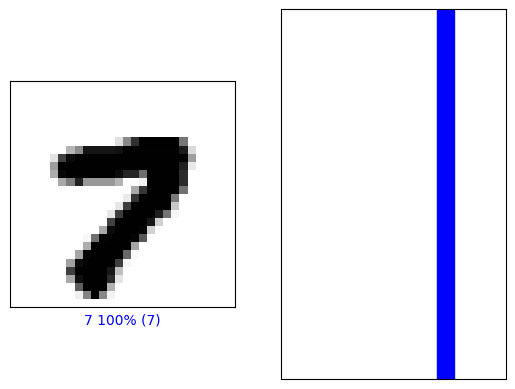

In [20]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 79 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions,  test_labels)
comet_model_2.log_figure(figure=plt)

Kita juga dapat menampilkan beberapa gambar beserta hasil prediksinya,  
dengan **label prediksi yang benar ditandai dengan warna biru**,  
dan **label prediksi yang salah ditandai dengan warna abu-abu**.  

Angka yang ditampilkan menunjukkan **persentase tingkat keyakinan model (dari 100%)** terhadap label yang diprediksi.  
Perhatikan bahwa model bisa saja **sangat yakin terhadap sebuah prediksi yang ternyata salah!**

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : nutritious_nucleus_121
COMET INFO:     url                   : https://www.comet.com/sigitpurnomo/6-s191lab2-part1-cnn/832c576c706b4b899b5a151307f2ee42
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 3
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, sklearn, tensorflow, torch.


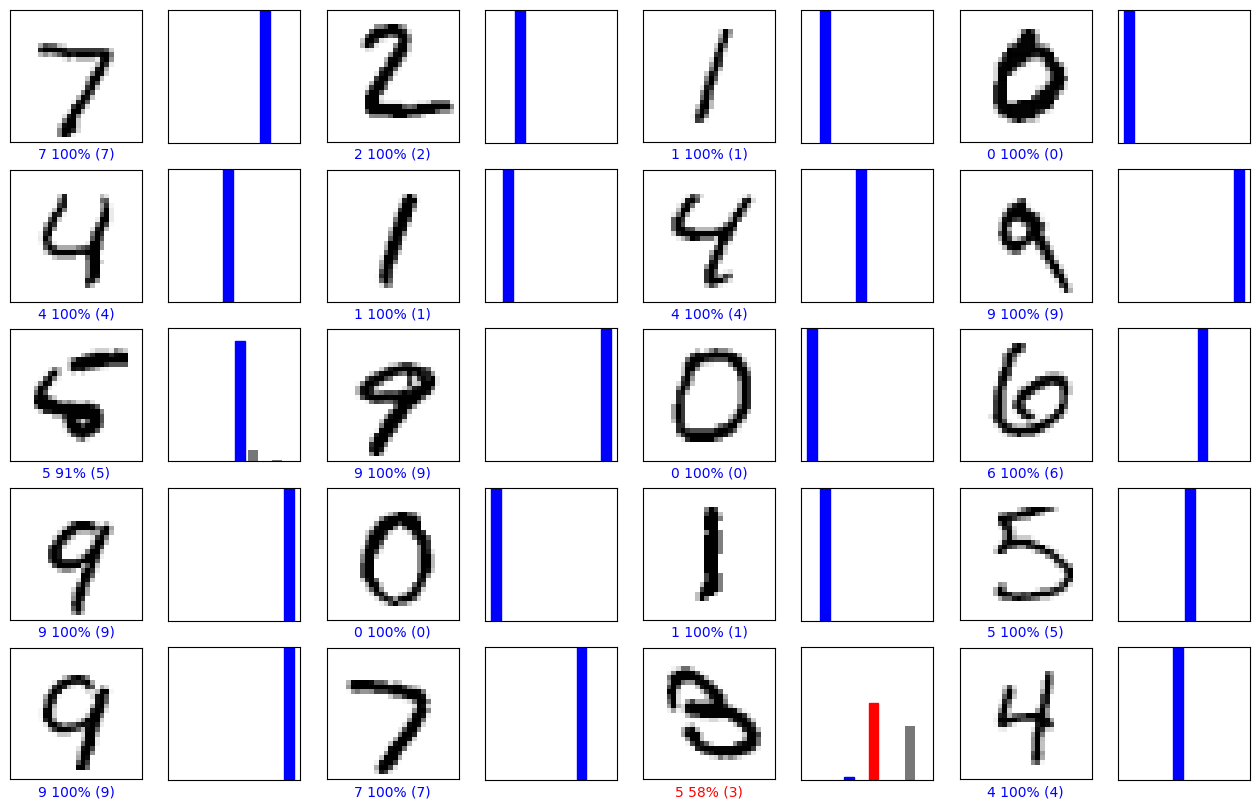

In [21]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)
comet_model_2.log_figure(figure=plt)
comet_model_2.end()


## 1.4 Melatih Model 2.0

Sebelumnya dalam praktikum ini, kita telah menggunakan fungsi [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) untuk melatih model. Fungsi ini bersifat **tingkat tinggi (high-level)** dan **mudah digunakan**, yang sangat bermanfaat untuk model-model yang lebih sederhana. Namun, seperti yang mungkin sudah kamu perhatikan, fungsi ini menyembunyikan banyak detail proses pelatihan di baliknya, sehingga kita memiliki **kendali yang lebih sedikit** terhadap proses pelatihan model — padahal dalam beberapa konteks, kontrol yang lebih besar bisa sangat berguna.

Sebagai alternatif, kita dapat menggunakan kelas [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) untuk **merekam operasi diferensiasi selama proses pelatihan**, dan kemudian memanggil fungsi [`tf.GradientTape.gradient`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) untuk benar-benar **menghitung gradiennya**. Kamu mungkin masih ingat penggunaannya pada **Lab 1 Bagian 1**, namun mari kita pelajari kembali di bagian ini.

Kita akan menggunakan kerangka kerja ini untuk **melatih `cnn_model` menggunakan metode stochastic gradient descent (SGD)**.

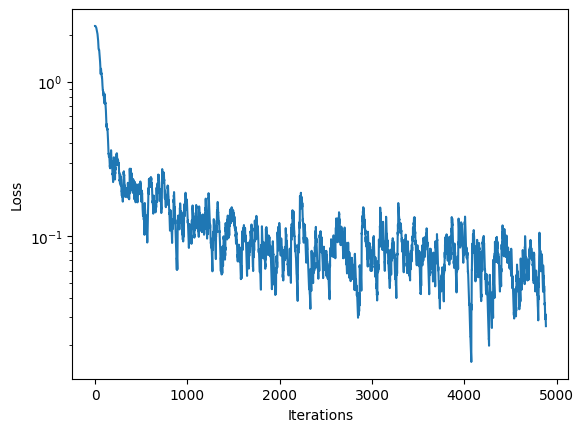

100%|██████████| 5000/5000 [00:47<00:00, 105.84it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : distant_refinery_2219
COMET INFO:     url                   : https://www.comet.com/sigitpurnomo/6-s191lab2-part1-cnn2/2571d1c3c10f4bfc8beb8e5393ef6511
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [5000] : (1.880358104244806e-05, 2.674870252609253)
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: 
COMET WARNING: To get 

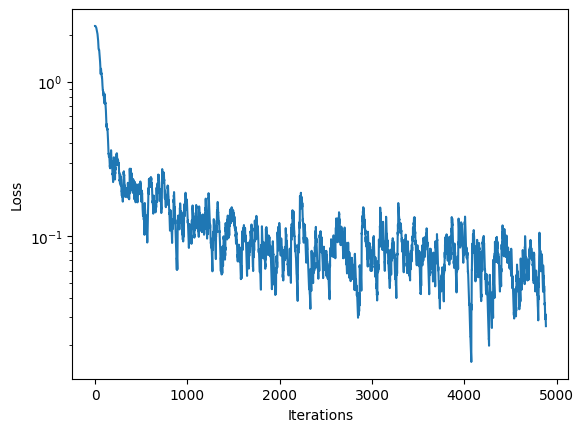

In [ ]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

comet_ml.init(project_name="6.s191lab2_part1_CNN2")
comet_model_3 = comet_ml.Experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    logits = cnn_model(____) # TODO (10)

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(____, ____) # TODO (10)
    comet_model_3.log_metric("loss", loss_value.numpy().mean(), step=idx)

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.'''
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))

comet_model_3.log_figure(figure=plt)
comet_model_3.end()
